In [1]:
# Import necessary libraries
import pandas as pd
# Initial imports
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
%matplotlib inline

import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.5.1'
spark_version = 'spark-3.5.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 229 kB in 7s (33.3 kB/s)
Reading package lists... Done


In [2]:
!pip install -q kaggle
from google.colab import drive
drive.mount('/content/drive')

import os
import shutil

# Move kaggle.json from Google Drive to appropriate directory
kaggle_token_path = '/content/drive/My Drive/kaggle.json'
kaggle_dir = '/root/.kaggle/'
if os.path.exists(kaggle_token_path):
    shutil.copy(kaggle_token_path, kaggle_dir)
    os.chmod(kaggle_dir + 'kaggle.json', 600)

# Download and unzip dataset
!kaggle datasets download -d alexteboul/diabetes-health-indicators-dataset
!unzip -o diabetes-health-indicators-dataset.zip


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
diabetes-health-indicators-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  diabetes-health-indicators-dataset.zip
  inflating: diabetes_012_health_indicators_BRFSS2015.csv  
  inflating: diabetes_binary_5050split_health_indicators_BRFSS2015.csv  
  inflating: diabetes_binary_health_indicators_BRFSS2015.csv  


In [3]:
# Initialize Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("Kaggle_Dataset") \
    .getOrCreate()

# Load dataset into Spark DataFrame
df = spark.read.csv("diabetes_binary_5050split_health_indicators_BRFSS2015.csv", header=True, inferSchema=True)
df.show()

+---------------+------+--------+---------+----+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+----+---------+------+
|Diabetes_binary|HighBP|HighChol|CholCheck| BMI|Smoker|Stroke|HeartDiseaseorAttack|PhysActivity|Fruits|Veggies|HvyAlcoholConsump|AnyHealthcare|NoDocbcCost|GenHlth|MentHlth|PhysHlth|DiffWalk|Sex| Age|Education|Income|
+---------------+------+--------+---------+----+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+----+---------+------+
|            0.0|   1.0|     0.0|      1.0|26.0|   0.0|   0.0|                 0.0|         1.0|   0.0|    1.0|              0.0|          1.0|        0.0|    3.0|     5.0|    30.0|     0.0|1.0| 4.0|      6.0|   8.0|
|            0.0|   1.0|     1.0|      1.0|26.0|   1.0|   1.0|                 0.0|         0.0|   1.0|    0.0|              0.0|   

In [4]:
# Show schema to confirm date type
df.printSchema()

root
 |-- Diabetes_binary: double (nullable = true)
 |-- HighBP: double (nullable = true)
 |-- HighChol: double (nullable = true)
 |-- CholCheck: double (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Smoker: double (nullable = true)
 |-- Stroke: double (nullable = true)
 |-- HeartDiseaseorAttack: double (nullable = true)
 |-- PhysActivity: double (nullable = true)
 |-- Fruits: double (nullable = true)
 |-- Veggies: double (nullable = true)
 |-- HvyAlcoholConsump: double (nullable = true)
 |-- AnyHealthcare: double (nullable = true)
 |-- NoDocbcCost: double (nullable = true)
 |-- GenHlth: double (nullable = true)
 |-- MentHlth: double (nullable = true)
 |-- PhysHlth: double (nullable = true)
 |-- DiffWalk: double (nullable = true)
 |-- Sex: double (nullable = true)
 |-- Age: double (nullable = true)
 |-- Education: double (nullable = true)
 |-- Income: double (nullable = true)



In [5]:
# Convert PySpark DataFrame to Pandas DataFrame
df = df.toPandas()

# Show the first few rows of the DataFrame
df.head()


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


In [6]:
df.columns

Index(['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

In [7]:
# Display basic information about the dataset
df.shape

(70692, 22)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       70692 non-null  float64
 1   HighBP                70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   Stroke                70692 non-null  float64
 7   HeartDiseaseorAttack  70692 non-null  float64
 8   PhysActivity          70692 non-null  float64
 9   Fruits                70692 non-null  float64
 10  Veggies               70692 non-null  float64
 11  HvyAlcoholConsump     70692 non-null  float64
 12  AnyHealthcare         70692 non-null  float64
 13  NoDocbcCost           70692 non-null  float64
 14  GenHlth               70692 non-null  float64
 15  MentHlth           

**Random Forests**

In [9]:
# Define features set
X = df.copy()
X.drop("Diabetes_binary", axis=1, inplace=True)
X.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


In [10]:
y = df["Diabetes_binary"]
y[:5]

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Diabetes_binary, dtype: float64

In [11]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)
# Display the shapes of the training and testing sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (53019, 21)
Shape of X_test: (17673, 21)
Shape of y_train: (53019,)
Shape of y_test: (17673,)


In [12]:
# Creating StandardScaler instance
scaler = StandardScaler()

In [13]:
# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

In [14]:
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

**Fitting the Random Forest Model**

In [15]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

In [16]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

**Making Predictions Using the Random Forest Model**

In [17]:
# Calculating the confusion matrix
predictions = rf_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [18]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,6132,2703
Actual 1,1935,6903


Accuracy Score : 0.7375657783058903
Classification Report
              precision    recall  f1-score   support

         0.0       0.76      0.69      0.73      8835
         1.0       0.72      0.78      0.75      8838

    accuracy                           0.74     17673
   macro avg       0.74      0.74      0.74     17673
weighted avg       0.74      0.74      0.74     17673



**Feature Importance**

In [19]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.17016614603325242, 'BMI'),
 (0.12585930932476258, 'Age'),
 (0.11021540899193581, 'GenHlth'),
 (0.0830435167286249, 'Income'),
 (0.07464462019216297, 'HighBP'),
 (0.06810181509913232, 'PhysHlth'),
 (0.056847450063427424, 'Education'),
 (0.05174905776835716, 'MentHlth'),
 (0.040388542581329685, 'HighChol'),
 (0.028342742123592904, 'Smoker'),
 (0.028226206479178863, 'Fruits'),
 (0.026733474036790206, 'Sex'),
 (0.025917242266527443, 'DiffWalk'),
 (0.023171990286804407, 'PhysActivity'),
 (0.021728945418456217, 'Veggies'),
 (0.019624027890576507, 'HeartDiseaseorAttack'),
 (0.012152518631073852, 'NoDocbcCost'),
 (0.010052282816617426, 'Stroke'),
 (0.009376883187391832, 'HvyAlcoholConsump'),
 (0.007497556461457094, 'AnyHealthcare'),
 (0.006160263618548057, 'CholCheck')]

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

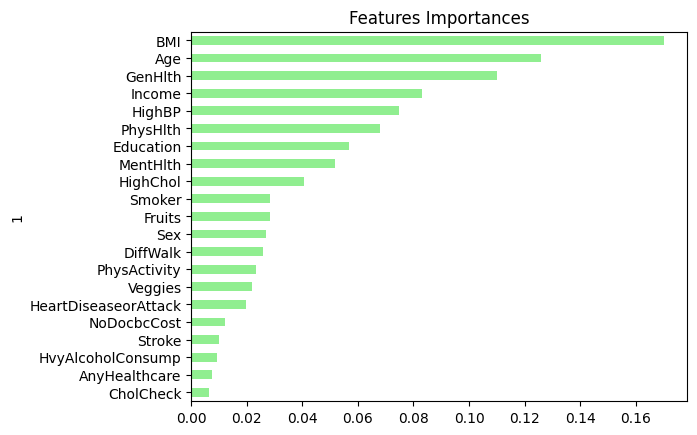

In [20]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

In [21]:
column =  ['PhysHlth', 'Education', 'MentHlth','HighChol', 'Smoker','Fruits', 'Sex', 'PhysActivity', 'DiffWalk', 'Veggies', 'HeartDiseaseorAttack', 'NoDocbcCost', 'Stroke', 'HvyAlcoholConsump', 'AnyHealthcare','PhysHlth']
# Drop the specified columns
df_features = df.drop(columns=column)

# Display the first few rows of the DataFrame after dropping columns
df_features.head()
# Export the DataFrame to a CSV file
# df_features.to_csv('/content/modified_dataset.csv', index=False)

,Diabetes_binary,HighBP,CholCheck,BMI,GenHlth,Age,Income
0,0.0,1.0,1.0,26.0,3.0,4.0,8.0
1,0.0,1.0,1.0,26.0,3.0,12.0,8.0
2,0.0,0.0,1.0,26.0,1.0,13.0,8.0
3,0.0,1.0,1.0,28.0,3.0,11.0,8.0
4,0.0,0.0,1.0,29.0,2.0,8.0,8.0


# Logistic Regression Model

In [22]:
# Logistic Regression Model Training
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)  # Training on scaled features

# Logistic Regression Model Evaluation
y_pred = log_reg.predict(X_test_scaled)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Generate confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.7479205567815311

Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.73      0.74      8835
         1.0       0.74      0.77      0.75      8838

    accuracy                           0.75     17673
   macro avg       0.75      0.75      0.75     17673
weighted avg       0.75      0.75      0.75     17673


Confusion Matrix:
[[6451 2384]
 [2071 6767]]


# Deep Learning Model

In [23]:
!pip install -q -U keras-tuner


In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import keras_tuner as kt
from sklearn.model_selection import train_test_split
import pandas as pd

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define input shape based on the shape of X_train
input_shape = X_train.shape[1]

# Define a function to build the model
def build_model(hp):
    model = Sequential()

    # Add the input layer
    model.add(Dense(units=hp.Int('input_units', min_value=16, max_value=128, step=16), activation='relu', input_shape=(input_shape,)))

    # Add additional hidden layers
    for i in range(hp.Int('num_layers', min_value=1, max_value=3)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=16, max_value=128, step=16), activation='relu'))

    # Add the output layer
    model.add(Dense(units=1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Initialize the tuner
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='keras_tuner_logs',
                     project_name='diabetes_prediction')

# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, verbose=1)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Save the model architecture as JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Save the model weights
model.save_weights("model_weights.h5")

# Record the performance metrics in the results DataFrame
results_df = pd.DataFrame({'Iteration': ['Final'],
                           'Test Loss': [loss],
                           'Test Accuracy': [accuracy]})

# Print or display the overall model performance metrics
print("Overall Model Performance:")
print(results_df)


Reloading Tuner from keras_tuner_logs/diabetes_prediction/tuner0.json
Epoch 1/20
1414/1414 [==============================] - 11s 7ms/step - loss: 0.5554 - accuracy: 0.7188 - val_loss: 0.5215 - val_accuracy: 0.7399
Epoch 2/20
1414/1414 [==============================] - 3s 2ms/step - loss: 0.5233 - accuracy: 0.7403 - val_loss: 0.5258 - val_accuracy: 0.7386
Epoch 3/20
1414/1414 [==============================] - 3s 2ms/step - loss: 0.5190 - accuracy: 0.7440 - val_loss: 0.5239 - val_accuracy: 0.7381
Epoch 4/20
1414/1414 [==============================] - 3s 2ms/step - loss: 0.5172 - accuracy: 0.7458 - val_loss: 0.5149 - val_accuracy: 0.7439
Epoch 5/20
1414/1414 [==============================] - 5s 3ms/step - loss: 0.5169 - accuracy: 0.7454 - val_loss: 0.5146 - val_accuracy: 0.7457
Epoch 6/20
1414/1414 [==============================] - 3s 2ms/step - loss: 0.5143 - accuracy: 0.7450 - val_loss: 0.5251 - val_accuracy: 0.7432
Epoch 7/20
1414/1414 [==============================] - 3s 2ms/st

In [25]:
# Evaluate the model using the test data
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


442/442 - 1s - loss: 0.5164 - accuracy: 0.7492 - 1s/epoch - 2ms/step
Test Loss: 0.5164411067962646, Test Accuracy: 0.7492043375968933


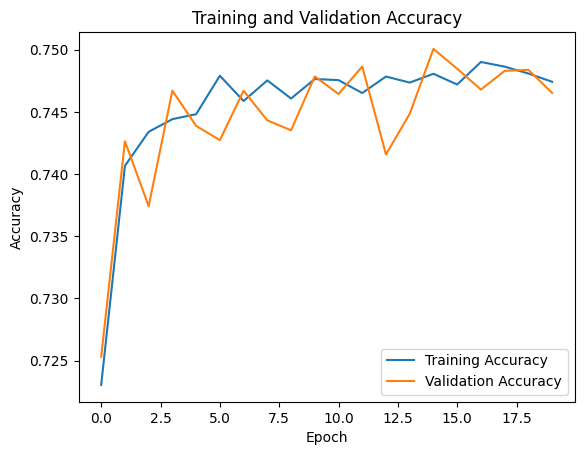

In [26]:
import matplotlib.pyplot as plt

# Visualize training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

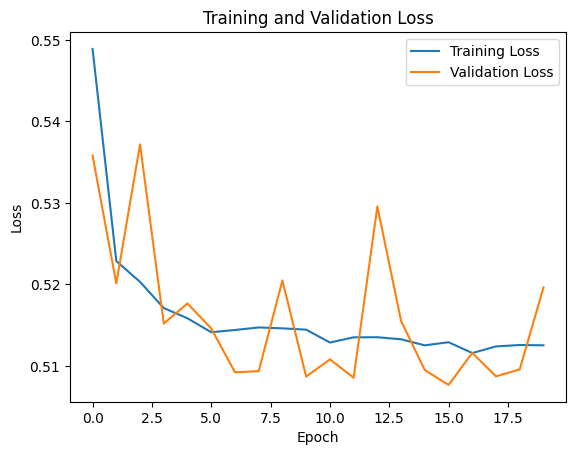

In [27]:
# Visualize training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()